In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Load CSV file
data = pd.read_csv('standardised_dataset.csv',header=None,low_memory=False)

In [2]:
data

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,-0.325484,-0.325926,-0.152455,-0.144238,-0.136613,-0.304554,-0.299140,-0.147937,-0.142891,-0.133432,...,0.419156,0.463063,0.463679,0.402541,0.405764,0.412294,0.293141,0.292716,0.332797,2
1,-0.129219,-0.112576,-0.107353,-0.099354,-0.110948,-0.105894,-0.111175,-0.109532,-0.104428,-0.069556,...,0.076667,0.071583,0.070139,0.165051,0.168331,0.286329,0.283272,0.282837,0.177171,2
2,0.334095,0.359380,0.363002,0.301392,0.309305,0.313855,0.446349,0.450549,0.357126,0.364803,...,-0.028715,-0.033689,-0.191118,-0.191184,-0.187819,-0.035212,-0.035830,-0.115613,-0.117527,1
3,-0.598968,-0.600695,-0.568043,-0.557808,-0.479873,-0.474377,-0.467991,-0.480785,-0.476235,-0.491140,...,0.241325,0.242650,0.242106,0.250811,0.254071,0.259810,0.230636,0.230149,0.263262,1
4,0.163570,0.165426,0.269576,0.275744,0.184191,0.188891,0.191481,0.197713,0.203275,0.316896,...,-0.219718,-0.224494,-0.227496,-0.267049,-0.263666,-0.320290,-0.318744,-0.319778,-0.339378,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,0.668711,0.672940,0.675499,0.634813,0.642941,0.605436,0.605642,0.610572,0.568671,0.575595,...,1.258913,1.262472,1.267294,1.263441,1.216995,1.227750,1.359005,1.359639,1.365894,3
1967,0.437054,0.482218,0.485424,0.314216,0.322137,0.326672,0.302986,0.306528,0.302637,0.310508,...,0.168875,0.163696,0.013919,0.013321,0.016637,-0.041842,-0.042409,0.072086,0.071212,3
1968,-0.290092,-0.290368,-0.284541,-0.323772,-0.316263,-0.291738,-0.286397,-0.285557,-0.248663,-0.238828,...,0.359879,0.354502,0.285098,0.283796,0.326620,0.332737,0.329328,0.272958,0.273196,3
1969,-0.608620,-0.610393,-0.603481,-0.564220,-0.556866,-0.541665,-0.534894,-0.535193,-0.489056,-0.478364,...,0.794577,0.788749,0.741472,0.738985,0.653091,0.660909,0.655008,0.641771,0.644051,3


In [3]:
# Assuming the PPG signals are in the first 3840 columns and the label is in the last column
X = data.iloc[:, :2099].values
y = data.iloc[:, -1].values

In [4]:
y

array([2, 2, 1, ..., 3, 3, 3], dtype=int64)

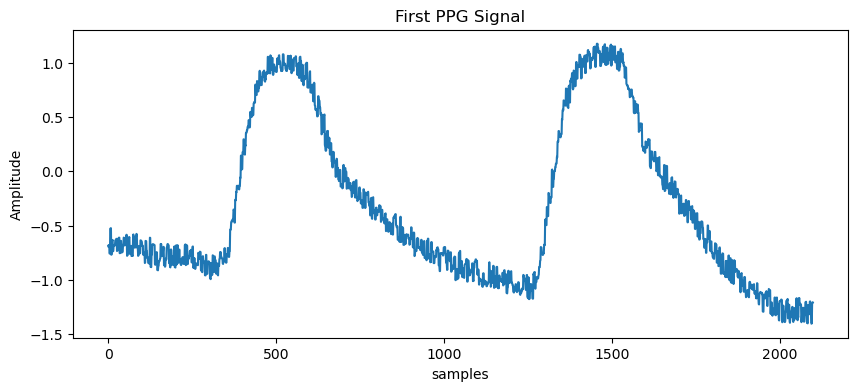

In [100]:
# Encode labels to integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Reshape data to fit the model input shape (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Visualize the first PPG signal
plt.figure(figsize=(10, 4))
plt.plot(X_train[409])
plt.title("First PPG Signal")
plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.show()

In [101]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Activation, Add, TimeDistributed, Reshape, GlobalAveragePooling1D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

In [102]:
X_train.shape

(1379, 2099, 1)

In [103]:

# Define Residual Block with Shape Matching
def residual_block(x, filters, kernel_size):
    shortcut = Conv1D(filters, 1, padding='same')(x)  # Ensure the shortcut has the same number of filters
    for _ in range(3):
        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
    x = Add()([shortcut, x])
    x = MaxPooling1D(pool_size=2)(x)
    return x

# Define TCN Block
def tcn_block(x, filters, kernel_size, dilation_rates):
    for dilation_rate in dilation_rates:
        shortcut = x
        x = Conv1D(filters, kernel_size, padding='same', dilation_rate=dilation_rate)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = Dropout(0.2)(x)
        x = Add()([shortcut, x])
    return x

# Define SleepPPG-Net Model
input_shape = (2099, 1)  # Adjust to match your data dimensions
inputs = Input(shape=input_shape)

# Feature Extraction (8 Residual Convolutional Blocks)
x = inputs
filter_sizes = [16, 16, 32, 32, 64, 64, 128, 256]
for filters in filter_sizes:
    x = residual_block(x, filters, 3)

# Windowing
x = Reshape((-1, 256))(x)  # Adjusting based on input/output dimensions in the image

# Time Distributed Dense Layer
x = TimeDistributed(Dense(128, activation='relu'))(x)

# Temporal Convolutional Network (2 TCN Blocks)
for _ in range(2):
    x = tcn_block(x, 128, 5, [1, 2, 4, 8, 16])

# Final Classification Layer
x = Conv1D(4, 1, activation='softmax')(x)  # Adjusted for 6 classes

# Define Model
model = Model(inputs=inputs, outputs=x)

# Compile Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 2099, 1)]    0           []                               
                                                                                                  
 conv1d_388 (Conv1D)            (None, 2099, 16)     64          ['input_10[0][0]']               
                                                                                                  
 batch_normalization_306 (Batch  (None, 2099, 16)    64          ['conv1d_388[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu_306 (LeakyReLU)    (None, 2099, 16)     0           ['batch_normalization_306[0

                                                                                                  
 leaky_re_lu_314 (LeakyReLU)    (None, 524, 32)      0           ['batch_normalization_314[0][0]']
                                                                                                  
 add_164 (Add)                  (None, 524, 32)      0           ['conv1d_395[0][0]',             
                                                                  'leaky_re_lu_314[0][0]']        
                                                                                                  
 max_pooling1d_74 (MaxPooling1D  (None, 262, 32)     0           ['add_164[0][0]']                
 )                                                                                                
                                                                                                  
 conv1d_400 (Conv1D)            (None, 262, 32)      3104        ['max_pooling1d_74[0][0]']       
          

 batch_normalization_323 (Batch  (None, 65, 64)      256         ['conv1d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv1d_407 (Conv1D)            (None, 65, 64)       4160        ['max_pooling1d_76[0][0]']       
                                                                                                  
 leaky_re_lu_323 (LeakyReLU)    (None, 65, 64)       0           ['batch_normalization_323[0][0]']
                                                                                                  
 add_167 (Add)                  (None, 65, 64)       0           ['conv1d_407[0][0]',             
                                                                  'leaky_re_lu_323[0][0]']        
                                                                                                  
 max_pooli

 dropout_90 (Dropout)           (None, 8, 128)       0           ['leaky_re_lu_330[0][0]']        
                                                                                                  
 add_170 (Add)                  (None, 8, 128)       0           ['time_distributed_9[0][0]',     
                                                                  'dropout_90[0][0]']             
                                                                                                  
 conv1d_420 (Conv1D)            (None, 8, 128)       82048       ['add_170[0][0]']                
                                                                                                  
 batch_normalization_331 (Batch  (None, 8, 128)      512         ['conv1d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 leaky_re_

                                                                                                  
 dropout_97 (Dropout)           (None, 8, 128)       0           ['leaky_re_lu_337[0][0]']        
                                                                                                  
 add_177 (Add)                  (None, 8, 128)       0           ['add_176[0][0]',                
                                                                  'dropout_97[0][0]']             
                                                                                                  
 conv1d_427 (Conv1D)            (None, 8, 128)       82048       ['add_177[0][0]']                
                                                                                                  
 batch_normalization_338 (Batch  (None, 8, 128)      512         ['conv1d_427[0][0]']             
 Normalization)                                                                                   
          

In [104]:
# Assuming each sequence has 15 time steps and the same label for all time steps
sequence_length = model.output_shape[1]  # This should be 15 based on your model architecture

# Repeat the target label for each time step
y_train_seq = np.repeat(y_train[:, np.newaxis], sequence_length, axis=1)
y_test_seq = np.repeat(y_test[:, np.newaxis], sequence_length, axis=1)



In [105]:
from tensorflow.keras.models import load_model

In [106]:
import pandas

In [107]:
import numpy as np

# Sample numpy array for y_test (replace this with your actual y_test array)
# y_test = np.array([...])

# Count the number of occurrences of each unique label
unique, counts = np.unique(y_test, return_counts=True)
label_counts = dict(zip(unique, counts))

# Print the count of each label
for label, count in label_counts.items():
    print(f"Label {label}: {count} occurrences")


Label 0: 218 occurrences
Label 1: 221 occurrences
Label 2: 99 occurrences
Label 3: 54 occurrences


In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, min_delta=0.001)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train_seq, epochs=100, batch_size=4, validation_data=(X_test, y_test_seq))


# Save the model
model.save('sleepppgnet_model_with_earlystopping_again_100.h5')


Epoch 1/100
345/345 [==============================] - 129s 303ms/step - loss: 2.1150 - accuracy: 0.3490 - val_loss: 1.6391 - val_accuracy: 0.3737
Epoch 2/100
284/345 [=======================>......] - ETA: 13s - loss: 1.6090 - accuracy: 0.3651

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [ ]:
# Predict the labels on the test set
# model = load_model('sleepppgnet_model_with_earlystopping_again.h5')
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_flat = y_train_seq.flatten()

# Calculate accuracy
accuracy = accuracy_score(y_test_flat, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

In [ ]:
def aggregate_predictions(model, X_test, y_test_seq):
    # Predict the probabilities for the test set
    y_pred = model.predict(X_test)
   
    # Aggregate predictions by averaging probabilities across all time steps
    avg_probabilities = np.mean(y_pred, axis=1)
    final_predictions = np.argmax(avg_probabilities, axis=1)
   
    # Get the true labels for the test set
    true_labels = y_test_seq[:, 0]  # All time steps have the same label, so we take the first one
   
    return final_predictions, true_labels

# Get the aggregated predictions and true labels
final_predictions, true_labels = aggregate_predictions(model, X_test, y_test_seq)

# Calculate accuracy
accuracy = accuracy_score(true_labels, final_predictions)
print(f'Accuracy: {accuracy:.4f}')

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, final_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
